In [ ]:
from main import str2bool
import argparse
import torch
import os
from model import Generator
from model import Discriminator
from torch.autograd import Variable
from torchvision.utils import save_image
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms

In [ ]:


parser = argparse.ArgumentParser()

parser.add_argument('--c_dim', type=int, default=5, help='dimension of domain labels (1st dataset)')
parser.add_argument('--c2_dim', type=int, default=8, help='dimension of domain labels (2nd dataset)')
parser.add_argument('--celeba_crop_size', type=int, default=178, help='crop size for the CelebA dataset')
parser.add_argument('--rafd_crop_size', type=int, default=256, help='crop size for the RaFD dataset')
parser.add_argument('--image_size', type=int, default=128, help='image resolution')
parser.add_argument('--g_conv_dim', type=int, default=64, help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=64, help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')

# Training configuration.
parser.add_argument('--dataset', type=str, default='CelebA', choices=['CelebA', 'RaFD', 'Both'])
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=200000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=100000, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')
parser.add_argument('--selected_attrs', '--list', nargs='+', help='selected attributes for the CelebA dataset',
                    default=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'])

# Test configuration.
parser.add_argument('--test_iters', type=int, default=200000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='test', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=True)

# Directories.
# parser.add_argument('--celeba_image_dir', type=str, default='data/celeba/images')
parser.add_argument('--celeba_image_dir', type=str, default='/local/scratch/a/rahman89/Datasets/CelebA/celeba/img_align_celeba')
parser.add_argument('--attr_path', type=str, default='/local/scratch/a/rahman89/Datasets/CelebA/celeba/list_attr_celeba.txt')
parser.add_argument('--rafd_image_dir', type=str, default='data/RaFD/train')
parser.add_argument('--log_dir', type=str, default='stargan/logs')
parser.add_argument('--model_save_dir', type=str, default='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/models')
parser.add_argument('--sample_dir', type=str, default='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/samples')
parser.add_argument('--result_dir', type=str, default='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/new_results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=10000)
parser.add_argument('--lr_update_step', type=int, default=1000)

# config = parser.parse_args()
config,_ = parser.parse_known_args()
print(config)

In [ ]:
from data_loader import get_loader
from solver import Solver

rafd_loader = None

# celeba_loader128 = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
#                                    config.celeba_crop_size, 128, config.batch_size,
#                                    'CelebA', config.mode, config.num_workers)

celeba_loader128 = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)


celeba_loader256 = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, 256, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)

S = Solver(celeba_loader128, rafd_loader, config)


# Creating a dataset with only males

In [ ]:
from torch.utils.data import Dataset, DataLoader

class celeba(Dataset):  #image and labels from image paths; not doing any transformation bcz input images are already transformed
	def __init__(self, labels, images, image_size=256):
		self.labels = labels
		self.images = images

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		image_tensor = self.images[idx]
		image_label = torch.Tensor(self.labels[idx])

		return image_tensor, image_label


male_images128=[]
male_images256=[]
male_labels=[]

for ld1, ld2 in zip(celeba_loader128,celeba_loader256):
    ids= (ld1[1][:,3]==1).nonzero().squeeze()
    # if len(ids.shape)>1:
    #     ids= ids.squeeze()


    lb= ld1[1][ids]
    img128= ld1[0][ids]

    img256= ld2[0][ids]

    if len(img128.shape)<=3:
        img128= img128.unsqueeze(0)

    if len(img256.shape)<=3:
        img256= img256.unsqueeze(0)

    if len(lb.shape)<=1:
        lb= lb.unsqueeze(0)

    # print(lb.shape)

    male_images128.append(img128)
    male_images256.append(img256)
    male_labels.append(lb)


male_images128 = torch.cat(male_images128)
male_images256 = torch.cat(male_images256)
male_labels = torch.cat(male_labels)

dataset128 = celeba(male_labels, male_images128)
dataset256 = celeba(male_labels, male_images256)
maleloader128 = torch.utils.data.DataLoader(dataset128, batch_size=config.batch_size, drop_last=True)
maleloader256 = torch.utils.data.DataLoader(dataset256, batch_size=config.batch_size, drop_last=True)

# male_labels.shape


In [ ]:
# testdata_path='/local/scratch/a/rahman89/PycharmProjects/EGSDE/data/celeba_hq/val/male',


In [ ]:
def create_labels(self, c_org, c_dim=5, selected_attrs=None):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.

    hair_color_indices = []
    for i, attr_name in enumerate(selected_attrs):
        if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
            hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.


        c_trg_list.append(c_trg.to(self.device))
    return c_trg_list

In [47]:


"""Translate images using StarGAN trained on a single dataset."""
# ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
# Load the trained generator.
S.restore_model(S.test_iters)



data_loader128 = maleloader128   #testing with only males
data_loader256 = maleloader256   #testing with only males





with torch.no_grad():

    orginal_images= []
    orginal_images256= []
    edited_images= []

    for (x_real, c_org), (x_real256, c_org256) in zip(data_loader128, data_loader256):

        # Prepare input images and target domain labels.
        x_real = x_real.to(S.device)

        # c_trg_list = S.create_labels(c_org, S.c_dim, S.dataset, S.selected_attrs)  #different combination of attribute change
        # target= torch.tensor([0,0,0,1,1]).view(1,-1).to(S.device)  # making everyone young and male for now
        # target = target.repeat(x_real.shape[0], 1)
        target= c_org.to(S.device)
        print(target.shape)
        target[:,3]=0  #making everyone male and keeping rest according to the original image
        c_trg_list = [target]


        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake= S.G(x_real, c_trg)
            print('output',x_fake.shape)
            x_fake_list.append(x_fake)



        orginal_images.append(x_real)
        orginal_images256.append(x_real256)
        edited_images.append(x_fake)

        # break

        # Save the translated images.
        # x_concat = torch.cat(x_fake_list, dim=3)
        # print('x_concat',x_concat.shape)
        # result_path = os.path.join(S.result_dir, '{}-images.jpg'.format(i+1))
        # not saving for now
        # save_image(S.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        # print('Saved real and fake images into {}...'.format(result_path))




Loading the trained models from step 200000...
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16, 3, 128, 128])
torch.Size([16, 5])
output torch.Size([16

In [48]:
from torchvision.utils import save_image

orginal_images= torch.cat(orginal_images)
orginal_images256= torch.cat(orginal_images256)
edited_images= torch.cat(edited_images)

filepath = "/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/IDDAG/original_celeba_128"
for iter, img in enumerate(orginal_images):
    save_image(S.denorm(img), f'{filepath}/img{iter}.png')

filepath = "/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/IDDAG/original_celeba_256"
for iter, img in enumerate(orginal_images256):
    save_image(S.denorm(img), f'{filepath}/img{iter}.png')

filepath = "/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/IDDAG/stargan_celeba_128"
for iter, img in enumerate(edited_images):
    save_image(S.denorm(img), f'{filepath}/img{iter}.png')

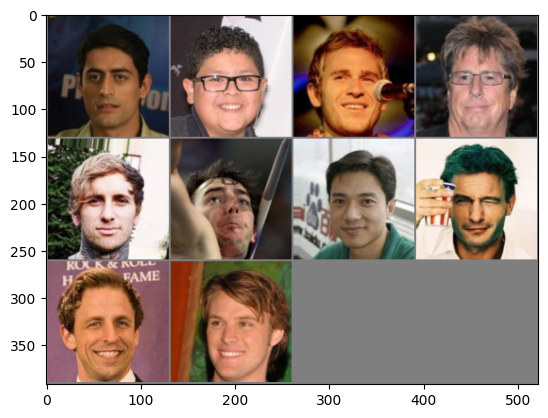

In [45]:
original_image, lb= orginal_images[0:10], c_trg
grid_img = torchvision.utils.make_grid(original_image, nrow=4)
plt.imshow(S.denorm(grid_img).cpu().permute(1, 2, 0))
# plt.imshow(grid_img.cpu().permute(1, 2, 0))
plt.show()


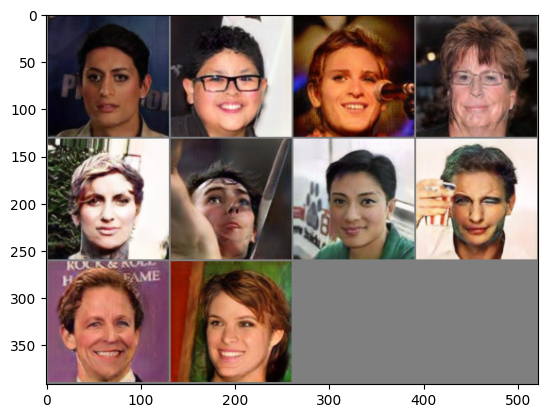

In [44]:

original_image, lb= edited_images[0:10], c_trg
grid_img = torchvision.utils.make_grid(original_image, nrow=4)
plt.imshow(S.denorm(grid_img).cpu().permute(1, 2, 0))
# plt.imshow(grid_img.cpu().permute(1, 2, 0))
plt.show()

In [ ]:
!pwd